In [ ]:
import nibabel as nib
import numpy as np
from nilearn import plotting, image
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from scipy.ndimage import label
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



Data shape: (64, 80, 33, 176)
Standard Deviation Data Shape with ADHD patient: (64, 80, 33)


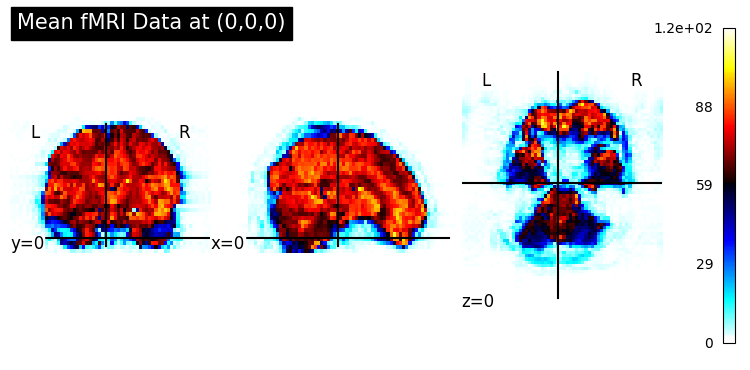

In [3]:

# Inspecting one random 4D fMRI data
nifti_file_path = r'F:\fmri-datasets\NYU\sub-0010001\ses-1\func\sub-0010001_ses-1_task-rest_run-1_bold.nii.gz'
img = nib.load(nifti_file_path)
data = img.get_fdata()  
img_load=image.load_img(nifti_file_path)
print("Data shape:", data.shape) 
affine = img.affine     # Extract the affine transformation matrix
header = img.header     # Extract the header

img_mean=np.mean(data, axis=3)
img_load_adhd = nib.Nifti1Image(img_mean, affine=affine, header=header)
plotting.plot_stat_map(
    img_load_adhd,
    title="Mean fMRI Data at (0,0,0)",
    display_mode='ortho',  
    threshold=0,           
    cut_coords=(0, 0, 0),  
bg_img=None)

# Calculate the standard deviation across the time dimension (axis=3)
std_dev_data = np.std(data, axis=3)

# Output the shape and an example of the result
print("Standard Deviation Data Shape with ADHD patient:", std_dev_data.shape)


Data shape: (64, 80, 33, 176)
Standard Deviation Data Shape with non-ADHD patient: (64, 80, 33)


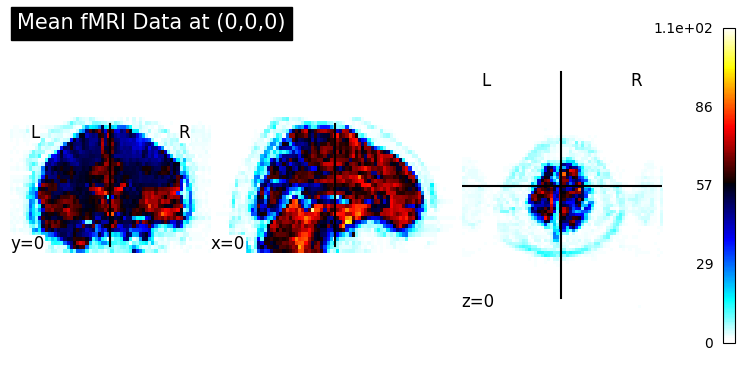

In [4]:

# Load a random 4D fMRI data
nifti_file_path = r'F:\fmri-datasets\NYU\sub-0010114\ses-1\func\sub-0010114_ses-1_task-rest_run-1_bold.nii.gz'
img = nib.load(nifti_file_path)
data = img.get_fdata()  
print("Data shape:", data.shape)
affine = img.affine     # Extract the affine transformation matrix
header = img.header     # Extract the header

img_mean=np.mean(data, axis=3)
img_load_non_adhd = nib.Nifti1Image(img_mean, affine=affine, header=header)
plotting.plot_stat_map(
    img_load_non_adhd,
    title="Mean fMRI Data at (0,0,0)",
    display_mode='ortho',  
    threshold=0,           
    cut_coords=(0, 0, 0),  
bg_img=None)

# Calculate the standard deviation across the time dimension (axis=3)
std_dev_data = np.std(data, axis=3)

# Output the shape and an example of the result
print("Standard Deviation Data Shape with non-ADHD patient:", std_dev_data.shape)

In [41]:
# Define the root directory
root_dir = 'F:/fmri-datasets/NYU'

# Concatenate the root directory with a specific file path
phenotypic_data_path = os.path.join(root_dir, 'participants.tsv')
print(phenotypic_data_path)

def get_scan_dir_ids(file_path):
    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t')  
    
    # Extract the 'participant_id' column values and convert them to a list
    participant_ids = df['participant_id'].tolist()
    
    return participant_ids

def get_fmri_path(sub_id):
    formatted_sub_id = f'{sub_id:07d}'
    # Create the path using os.path.join
    fmri_path = os.path.join(
        root_dir,
        f'sub-{formatted_sub_id}',
        'ses-1',
        'func',
        f'sub-{formatted_sub_id}_ses-1_task-rest_run-1_bold.nii.gz'
    )
    return fmri_path

participant_IDS = get_scan_dir_ids(phenotypic_data_path)
fmri_file_path_list=[]
valid_participant_IDS=[]
# Loop through all subject IDs and find the fMRI file paths
for sub_id in participant_IDS:
    fmri_file_path = get_fmri_path(sub_id)
    if os.path.exists(fmri_file_path):
        fmri_file_path_list.append(fmri_file_path)
        valid_participant_IDS.append(sub_id)
    else:
        print(f"File Not found: {fmri_file_path}")

print(len(valid_participant_IDS))
print("working dataset count: ", len(fmri_file_path_list), fmri_file_path_list)

F:/fmri-datasets/NYU\participants.tsv
File Not found: F:/fmri-datasets/NYU\sub-0010016\ses-1\func\sub-0010016_ses-1_task-rest_run-1_bold.nii.gz
File Not found: F:/fmri-datasets/NYU\sub-0010055\ses-1\func\sub-0010055_ses-1_task-rest_run-1_bold.nii.gz
File Not found: F:/fmri-datasets/NYU\sub-0010098\ses-1\func\sub-0010098_ses-1_task-rest_run-1_bold.nii.gz
File Not found: F:/fmri-datasets/NYU\sub-0010105\ses-1\func\sub-0010105_ses-1_task-rest_run-1_bold.nii.gz
File Not found: F:/fmri-datasets/NYU\sub-0010027\ses-1\func\sub-0010027_ses-1_task-rest_run-1_bold.nii.gz
File Not found: F:/fmri-datasets/NYU\sub-0010127\ses-1\func\sub-0010127_ses-1_task-rest_run-1_bold.nii.gz
298
working dataset count:  298 ['F:/fmri-datasets/NYU\\sub-0021002\\ses-1\\func\\sub-0021002_ses-1_task-rest_run-1_bold.nii.gz', 'F:/fmri-datasets/NYU\\sub-0021003\\ses-1\\func\\sub-0021003_ses-1_task-rest_run-1_bold.nii.gz', 'F:/fmri-datasets/NYU\\sub-0021005\\ses-1\\func\\sub-0021005_ses-1_task-rest_run-1_bold.nii.gz', 'F

In [42]:
def filter_participants_by_dx(file_path):

    df = pd.read_csv(file_path, sep='\t')     
    # Initialize empty lists to hold participant IDs for each category
    participant_IDS_ADHD_combined = []
    participant_IDS_ADHD_inattentive = []
    participant_IDS_non_ADHD = []
    
    for index, row in df.iterrows():
        participant_id = row['participant_id']
        diagnosis = row['dx']
        
        if participant_id in valid_participant_IDS:
            if diagnosis == 'ADHD-Combined' or diagnosis=='ADHD-Hyperactive/Impulsive':
                participant_IDS_ADHD_combined.append(participant_id)
            elif diagnosis == 'ADHD-Inattentive':
                participant_IDS_ADHD_inattentive.append(participant_id)
            elif diagnosis == 'Typically Developing Children':
                participant_IDS_non_ADHD.append(participant_id)
            else:
                print( participant_id, "UNKNOWN CATEGORY.....")
    return participant_IDS_ADHD_combined, participant_IDS_ADHD_inattentive, participant_IDS_non_ADHD

participant_IDS_ADHD_combined, participant_IDS_ADHD_inattentive, participant_IDS_non_ADHD = filter_participants_by_dx(phenotypic_data_path)

print("ADHD Combined IDs:",len(participant_IDS_ADHD_combined), participant_IDS_ADHD_combined)
print("ADHD Inattentive IDs:", len(participant_IDS_ADHD_inattentive), participant_IDS_ADHD_inattentive)
print("Non-ADHD (Typically Developing Children) IDs:",len(participant_IDS_non_ADHD), participant_IDS_non_ADHD)
print("Total number of subjects: ", len(participant_IDS_ADHD_combined)+len(participant_IDS_ADHD_inattentive)+len(participant_IDS_non_ADHD))

ADHD Combined IDs: 119 [21002, 21006, 21008, 21009, 21013, 21014, 21015, 21022, 21023, 21026, 21030, 21031, 21032, 21033, 21035, 21036, 21039, 21040, 21042, 21043, 21044, 21046, 21002, 21006, 21008, 21009, 21013, 21014, 21015, 21022, 21023, 21026, 21030, 21031, 21032, 21033, 21035, 21036, 21039, 21040, 21042, 21043, 21044, 21046, 1057962, 1099481, 1187766, 1283494, 1497055, 1517240, 1780174, 1918630, 1992284, 2030383, 2054438, 2107638, 2230510, 2260910, 2306976, 2497695, 2570769, 2682736, 2741068, 2950672, 3174224, 3235580, 3433846, 3457975, 3542588, 3601861, 3619797, 3653737, 3679455, 4095229, 4116166, 4154672, 4187857, 5164727, 5971050, 8697774, 8915162, 9326955, 10005, 10012, 10018, 10020, 10022, 10032, 10037, 10042, 10044, 10050, 10048, 10060, 10047, 10064, 10109, 10019, 10078, 10090, 10091, 10095, 10101, 10118, 10026, 10074, 10103, 10085, 10086, 10025, 10029, 10017, 10049, 10072, 10073, 10040, 10041, 10126, 10013]
ADHD Inattentive IDs: 57 [21003, 21010, 21017, 21021, 21025, 21027,

In [ ]:

def split_data(sub_ids, test_size=0.2, random_state=42):
    
    train_ids, test_ids = train_test_split(sub_ids, test_size=test_size, random_state=random_state)
    return train_ids, test_ids

# Splitting the data for each category
train_ADHD_combined, test_ADHD_combined = split_data(participant_IDS_ADHD_combined)
train_ADHD_inattentive, test_ADHD_inattentive = split_data(participant_IDS_ADHD_inattentive)
train_non_ADHD, test_non_ADHD = split_data(participant_IDS_non_ADHD)

# Output the results
print("Training set (ADHD Combined):", len(train_ADHD_combined), train_ADHD_combined)
print("Testing set (ADHD Combined):", len(test_ADHD_combined), test_ADHD_combined)

print("Training set (ADHD Inattentive):", len(train_ADHD_inattentive), train_ADHD_inattentive)
print("Testing set (ADHD Inattentive):", len(test_ADHD_inattentive), test_ADHD_inattentive)

print("Training set (Non-ADHD):", len(train_non_ADHD), train_non_ADHD)
print("Testing set (Non-ADHD):", len(test_non_ADHD), test_non_ADHD)


Training set (ADHD Combined): 95 [1057962, 21032, 21036, 3619797, 10086, 21008, 3433846, 21002, 21035, 2107638, 9326955, 21023, 2741068, 3679455, 21026, 21031, 10073, 3542588, 21015, 1283494, 10018, 21014, 5164727, 3457975, 21040, 1517240, 21033, 21039, 3235580, 21032, 10020, 21022, 21046, 10072, 5971050, 21014, 21043, 10047, 10026, 21009, 21023, 21033, 10012, 21009, 21040, 21039, 10050, 21015, 4187857, 10095, 10060, 2054438, 1780174, 10025, 1187766, 8915162, 2682736, 10040, 8697774, 10041, 21043, 2306976, 1497055, 10091, 2260910, 4154672, 21030, 10017, 2497695, 2950672, 10078, 21036, 21022, 10074, 21006, 1992284, 21046, 21008, 21006, 10118, 10090, 10032, 10085, 4116166, 10022, 10005, 10013, 21044, 2570769, 3653737, 10103, 21035, 10048, 1918630, 10101]
Testing set (ADHD Combined): 24 [2230510, 10042, 21013, 1099481, 21013, 10126, 3601861, 21030, 10044, 4095229, 21042, 10049, 21031, 10109, 21044, 21026, 10037, 21002, 10019, 10029, 3174224, 21042, 10064, 2030383]
Training set (ADHD Inatt

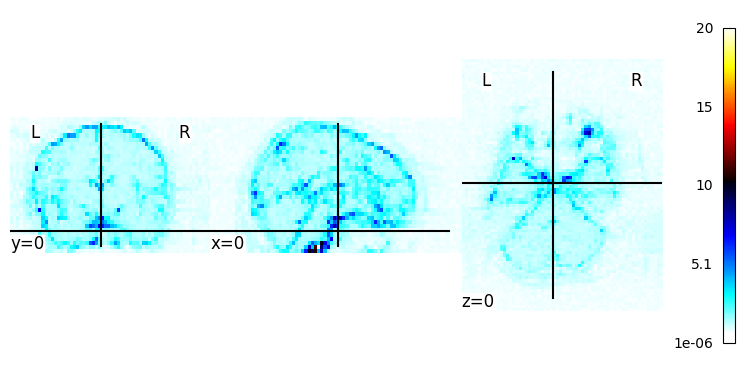

In [ ]:

# fmri_file_path = get_fmri_path(21036)

# img = nib.load(fmri_file_path)
# data = img.get_fdata()  # Load 4D data
# affine = img.affine
# header = img.header
# sd_matrix = np.std(data, axis=3)
# SD_random_subject = nib.Nifti1Image(sd_matrix, affine=affine, header=header)
# plotting.plot_stat_map(SD_random_subject, display_mode='ortho', title='', cut_coords=(0, 0, 0),
#                    bg_img=None)


In [ ]:

def calculate_group_sd(subject_ids):
    accumulated_sd = None
    subject_count = 0
    reference_affine = None
    reference_header = None

    for sub_id in subject_ids:

        fmri_file_path = get_fmri_path(sub_id)
        
        # Check if the file exists
        if not os.path.exists(fmri_file_path):
            print(f"File not found for subject {sub_id}: {fmri_file_path}")
            continue

        # Load the fMRI data
        img = nib.load(fmri_file_path)
        data = img.get_fdata()  # Load 4D data
        affine = img.affine
        header = img.header

        if reference_affine is None:
            reference_affine = affine
            reference_header = header

        print(f"Working on subject: {sub_id}")
        # Calculate the standard deviation along the 4th dimension (time)
        sd_matrix = np.std(data, axis=3)

        # Accumulate the SD matrices
        if accumulated_sd is None:
            accumulated_sd = sd_matrix
        else:
            accumulated_sd += sd_matrix

        subject_count += 1  # Count valid subjects

    # Calculate the average SD matrix
    if subject_count > 0:
        average_sd = accumulated_sd / subject_count
    else:
        raise ValueError("No valid subjects found for calculating the average SD.")

    return average_sd, reference_affine, reference_header


# Calculate average SD matrices for subjects with ADHD
participant_IDS_ADHD = train_ADHD_combined + train_ADHD_inattentive
std_dev_data_adhd, affine, header = calculate_group_sd(participant_IDS_ADHD)
# Save the ADHD average SD matrix as a NIfTI file
adhd_output_file = 'average_sd_adhd.nii.gz'
adhd_nifti_image = nib.Nifti1Image(std_dev_data_adhd, affine=affine, header=header)
nib.save(adhd_nifti_image, adhd_output_file)
print(f"The average SD NIfTI file for ADHD subjects has been saved as '{adhd_output_file}'.")


# Calculate average SD matrices for subjects with no ADHD
std_dev_data_non_adhd, affine, header = calculate_group_sd(train_non_ADHD)
# Save the non-ADHD average SD matrix as a NIfTI file
non_adhd_output_file = 'average_sd_non_adhd.nii.gz'
non_adhd_nifti_image = nib.Nifti1Image(std_dev_data_non_adhd, affine=affine, header=header)
nib.save(non_adhd_nifti_image, non_adhd_output_file)
print(f"The average SD NIfTI file for non-ADHD subjects has been saved as '{non_adhd_output_file}'.")



The ADHD average SD data has been loaded.
The non-ADHD average SD data has been loaded.


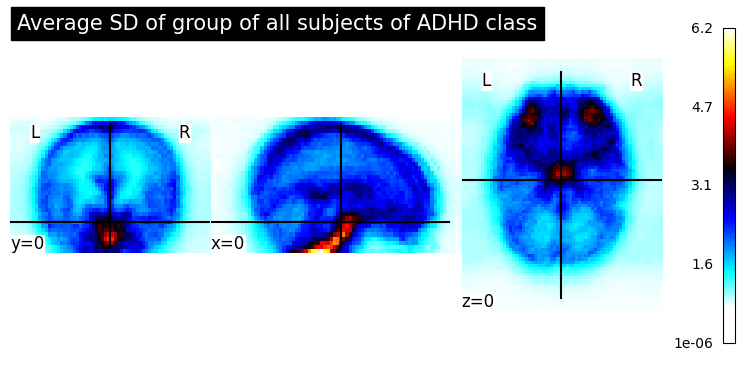

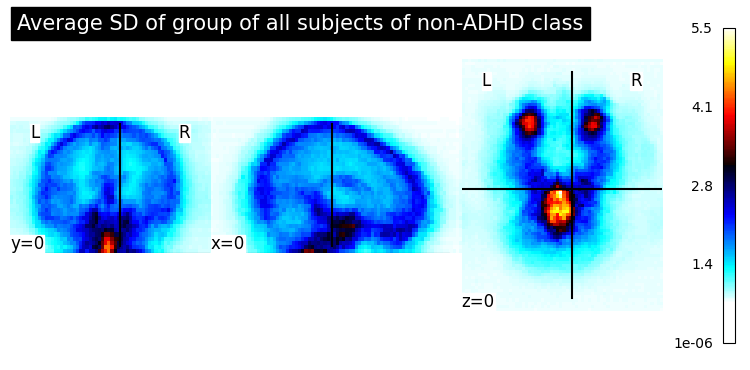

In [72]:
# Load the saved NIfTI file for ADHD subjects
adhd_nifti_image = nib.load('average_sd_adhd.nii.gz')
std_dev_data_adhd = adhd_nifti_image.get_fdata()
print("The ADHD average SD data has been loaded.")

# Load the saved NIfTI file for non-ADHD subjects
non_adhd_nifti_image = nib.load('average_sd_non_adhd.nii.gz')
std_dev_data_non_adhd = non_adhd_nifti_image.get_fdata()
print("The non-ADHD average SD data has been loaded.")


plotting.plot_stat_map(adhd_nifti_image, display_mode='ortho', title='Average SD of group of all subjects of ADHD class', cut_coords=(0, 0, 0),
                    bg_img=None)


plotting.plot_stat_map(non_adhd_nifti_image, display_mode='ortho', title='Average SD of group of all subjects of non-ADHD class', cut_coords=(0, 0, 0),
                    bg_img=None)

In [48]:

# Mean
mean_non_adhd = np.mean(std_dev_data_non_adhd)
mean_adhd = np.mean(std_dev_data_adhd)

# Median
median_non_adhd = np.median(std_dev_data_non_adhd)
median_adhd = np.median(std_dev_data_adhd)

# Minimum value
min_non_adhd = np.min(std_dev_data_non_adhd)
min_adhd = np.min(std_dev_data_adhd)

# Maximum value
max_non_adhd = np.max(std_dev_data_non_adhd)
max_adhd = np.max(std_dev_data_adhd)

# Range (Max - Min)
range_non_adhd = max_non_adhd - min_non_adhd
range_adhd = max_adhd - min_adhd


# Print calculated statistics
print(f"Non-ADHD Data Statistics: Mean={mean_non_adhd}, Median={median_non_adhd}, Min={min_non_adhd}, Max={max_non_adhd}, Range(high-low)={range_non_adhd}")
print(f"ADHD Data Statistics: Mean={mean_adhd}, Median={median_adhd}, Min={min_adhd}, Max={max_adhd}, Range(high-low)={range_adhd}")


Non-ADHD Data Statistics: Mean=1.2137797383295204, Median=0.9323903918266296, Min=0.6917251944541931, Max=5.508246421813965, Range(high-low)=4.816521227359772
ADHD Data Statistics: Mean=1.2621956448190648, Median=0.9393837153911591, Min=0.6927507519721985, Max=6.219798564910889, Range(high-low)=5.52704781293869


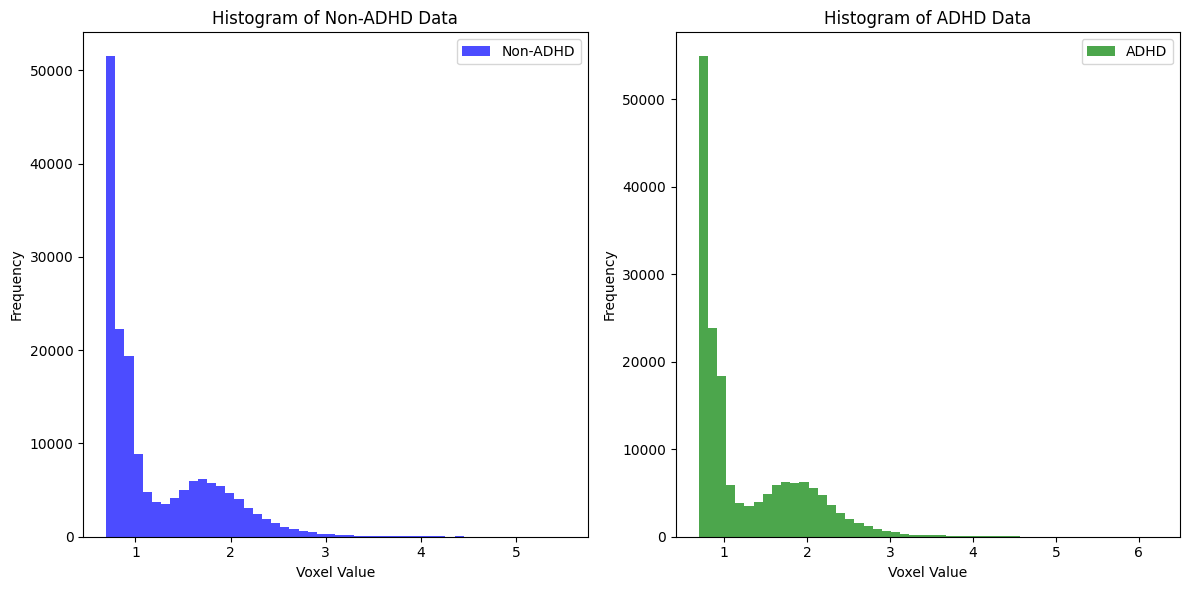

In [49]:
# Calculate histogram bins and plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(std_dev_data_non_adhd.ravel(), bins=50, color='blue', alpha=0.7, label='Non-ADHD')
plt.title('Histogram of Non-ADHD Data')
plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(std_dev_data_adhd.ravel(), bins=50, color='green', alpha=0.7, label='ADHD')
plt.title('Histogram of ADHD Data')
plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


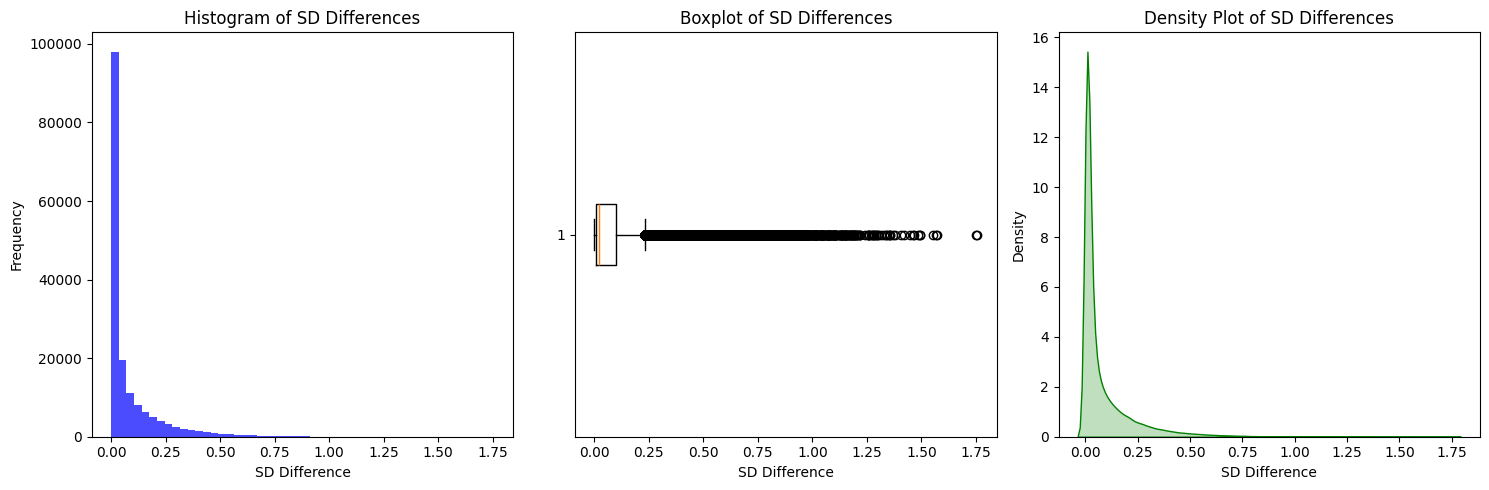

In [51]:

adhd_sd = std_dev_data_adhd 
non_adhd_sd = std_dev_data_non_adhd  

# Calculate the absolute difference matrix
sd_diff_matrix = np.abs(adhd_sd - non_adhd_sd)

# Flatten the matrix to 1D array
sd_diff_flattened = sd_diff_matrix.flatten()

plt.figure(figsize=(15, 5))

# Histogram with log scale
plt.subplot(1, 3, 1)
plt.hist(sd_diff_flattened, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of SD Differences')
plt.xlabel('SD Difference')
plt.ylabel('Frequency')

# Boxplot with log scale
plt.subplot(1, 3, 2)
plt.boxplot(sd_diff_flattened, vert=False)
plt.title('Boxplot of SD Differences')
plt.xlabel('SD Difference')

# Density Plot with log scale
plt.subplot(1, 3, 3)
sns.kdeplot(sd_diff_flattened, fill=True, color='green')
plt.title('Density Plot of SD Differences')
plt.xlabel('SD Difference')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


**Voxels before thresholding**

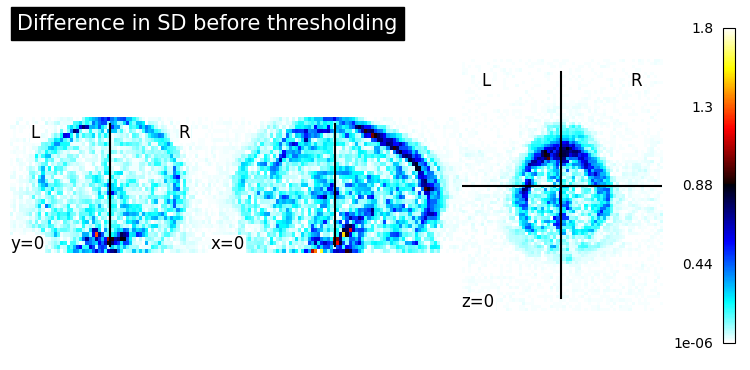

In [52]:

voxels_ROI_initial = nib.Nifti1Image(sd_diff_matrix, affine=affine, header=header)
plotting.plot_stat_map(voxels_ROI_initial, display_mode='ortho', title='Difference in SD before thresholding', cut_coords=(0, 0, 0),
                   bg_img=None)
                
plotting.show()

**Percentile thresholding**

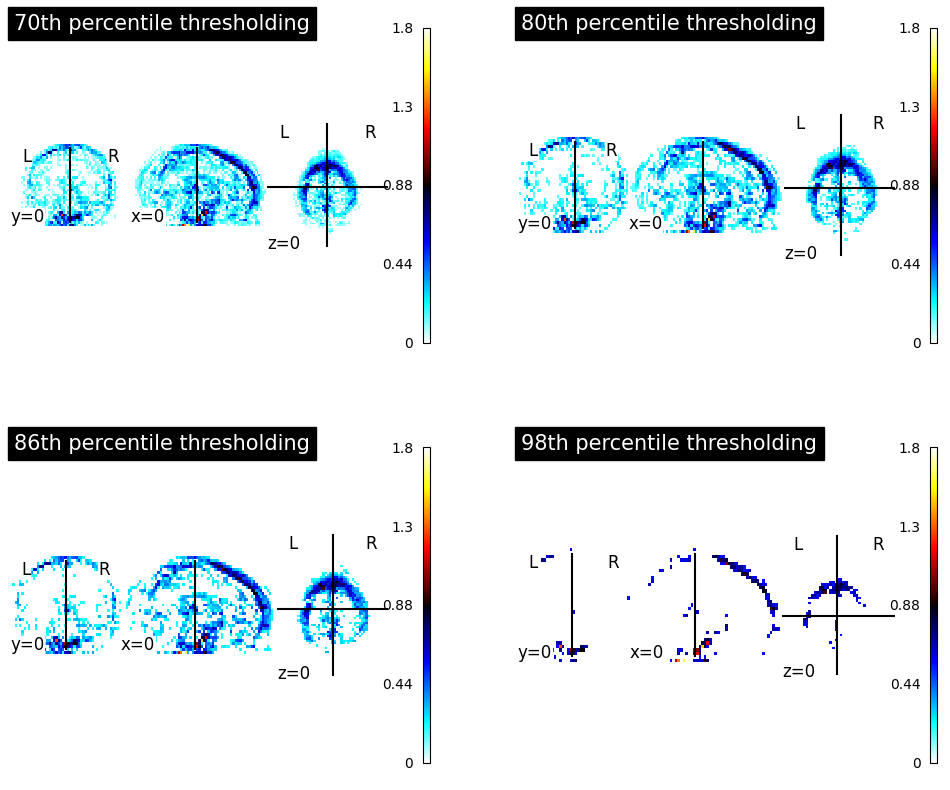

In [53]:

percentiles = [70, 80, 86, 98]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 grid for easier indexing

for i, percentile in enumerate(percentiles):
    # Calculate the threshold value
    percentile_value = np.percentile(sd_diff_flattened, percentile)
    title= f"{percentile}th percentile thresholding"
    # Create a new matrix based on the threshold
    thresholded_matrix = np.where(sd_diff_matrix > percentile_value, sd_diff_matrix, 0)
    
    # Check if the matrix contains any non-zero values
    if np.count_nonzero(thresholded_matrix) == 0:
        print(f"No data above the {percentile}th percentile threshold.")
        continue  # Skip plotting if there's no data

    thresholded_image = nib.Nifti1Image(thresholded_matrix, affine=affine, header=header)
    
    # Plot each thresholded image in a subplot
    plotting.plot_stat_map(
        thresholded_image,
        title=title,
        display_mode='ortho',
        threshold=0,
        cut_coords=(0, 0, 0),
        colorbar=True,
        bg_img=None,
        axes=axes[i],
        figure=fig
    )
    
# Show the combined plots
plt.show()




Applying Otsu's thresholding

In [54]:


flattened_data = sd_diff_matrix.flatten()
min_val = np.min(flattened_data)
max_val = np.max(flattened_data)
print("Min value in SD diff: ", min_val)
print("Max value in SD diff: ", max_val)

# Histogram computation for the data
hist, bin_edges = np.histogram(flattened_data, bins=128, range=(flattened_data.min(), flattened_data.max()))

# Compute cumulative sums and cumulative means
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2  # Mid-points of bins
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]
mean1 = np.cumsum(hist * bin_mids) / weight1
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

# Intra-class variance
variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Find the threshold that minimizes intra-class variance
index_of_max_variance = np.argmax(variance12)
otsu_threshold = bin_mids[:-1][index_of_max_variance]

print(f"Otsu's threshold value using numpy: {otsu_threshold}")
# Apply the threshold
thresholded_flattened = np.where(flattened_data >otsu_threshold, flattened_data, 0)
thresholded_sd_diff = thresholded_flattened.reshape(sd_diff_matrix.shape)

# Create a binary mask from the Otsu thresholded data
binary_mask = np.where(thresholded_sd_diff != 0, 1, 0)
unique_values = np.unique(binary_mask)
print(f"Unique values in the mask: {unique_values}")

# Save the mask as a NIfTI file
mask_output_file = 'voxel_mask_ROI_adhd.nii.gz'
mask_nifti_image = nib.Nifti1Image(binary_mask, affine=affine, header=header)
nib.save(mask_nifti_image, mask_output_file)
print(f"The binary voxel mask for ADHD has been saved as '{mask_output_file}'.")





Min value in SD diff:  5.960464477539063e-08
Max value in SD diff:  1.757249355316162
Otsu's threshold value using numpy: 0.1990634563844651
Unique values in the mask: [0 1]
The binary voxel mask for ADHD has been saved as 'voxel_mask_ROI_adhd.nii.gz'.


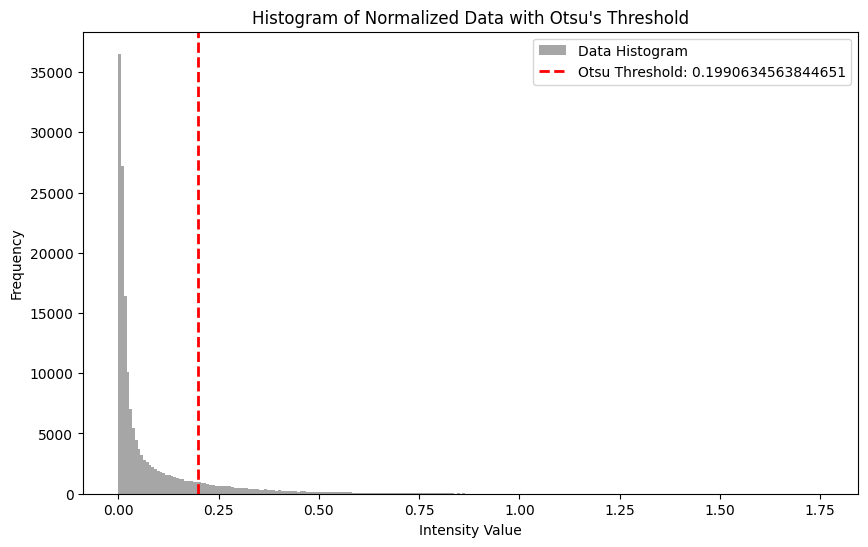

Shape of flattened data: (168960,)
otsu_threshold: 0.1990634563844651


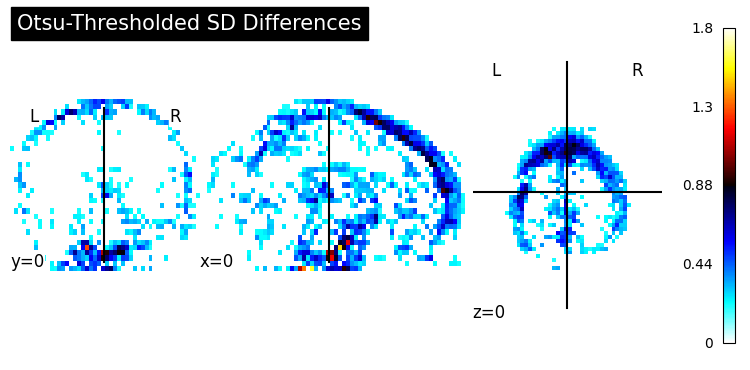

In [55]:

thresholded_img = nib.Nifti1Image(thresholded_sd_diff, affine=affine)


# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=256, range=(flattened_data.min(), flattened_data.max()), color='gray', alpha=0.7, label='Data Histogram')
plt.axvline(otsu_threshold, color='red', linestyle='dashed', linewidth=2, label=f'Otsu Threshold: {otsu_threshold}')
plt.title('Histogram of Normalized Data with Otsu\'s Threshold')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print(f"Shape of flattened data: {flattened_data.shape}")
print(f"otsu_threshold: {otsu_threshold}") 

# Visualize the thresholded data using nilearn
plotting.plot_stat_map(
    thresholded_img,
    title="Otsu-Thresholded SD Differences",
    display_mode='ortho',
    threshold=0,
    cut_coords=(0, 0, 0),
    colorbar=True,
    bg_img=None
)
plotting.show()

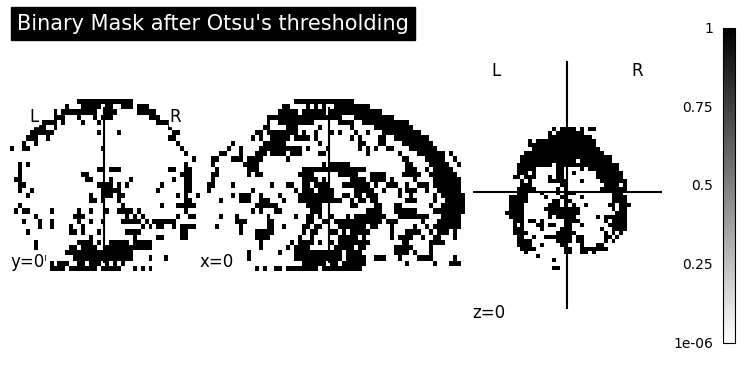

In [56]:
# Load the saved NIfTI file
mask_nifti_image = nib.load('voxel_mask_ROI_adhd.nii.gz')

# Define a custom colormap (white for 0s and black for 1s)
cmap = LinearSegmentedColormap.from_list('black_white_cmap', ['white', 'black'])
# Plot using the custom colormap
plotting.plot_stat_map(mask_nifti_image, display_mode='ortho', title='Binary Mask after Otsu\'s thresholding', cut_coords=(0, 0, 0),
                   bg_img=None, cmap=cmap)

plotting.show()

Number of clusters found using CCA: 1288
Connected Component Analysis result saved as 'cca_labeled_clusters.nii.gz'.
K-Means clustering result saved as 'kmeans_clustered_image.nii.gz'.


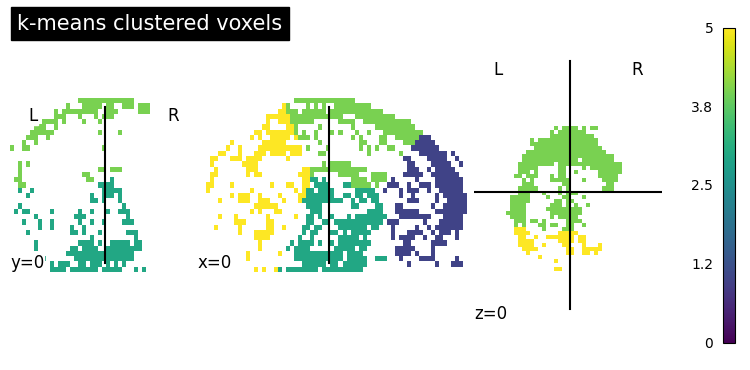

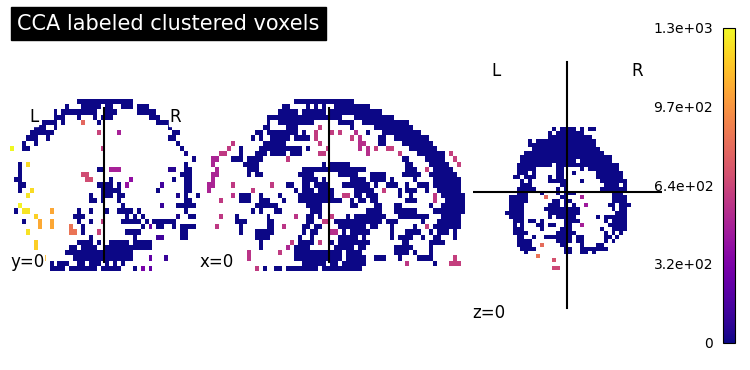

In [57]:


# Connected Component Analysis (CCA)
# Label connected components in the thresholded data
labeled_array, num_features = label(thresholded_sd_diff > 0) 
print(f"Number of clusters found using CCA: {num_features}")

# Save the labeled CCA result as a NIfTI file
cca_img = nib.Nifti1Image(labeled_array.astype(np.int32), affine=affine)
nib.save(cca_img, 'cca_labeled_clusters.nii.gz')
print("Connected Component Analysis result saved as 'cca_labeled_clusters.nii.gz'.")


# K-Means Clustering

# Flatten the data and keep non-zero values for clustering
non_zero_mask = thresholded_sd_diff > 0
data_points = np.argwhere(non_zero_mask)  # Extract coordinates of non-zero points
intensities = thresholded_sd_diff[non_zero_mask].reshape(-1, 1)

# Combine coordinates and intensities for clustering
features = np.hstack((data_points, intensities))

# Apply k-means clustering
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
labels = kmeans.labels_

# Map the k-means labels back to the original shape
kmeans_clustered_image = np.zeros_like(thresholded_sd_diff, dtype=np.int32)
kmeans_clustered_image[non_zero_mask] = labels   # Add 1 to avoid using 0 as a label

# Save the K-means result as a NIfTI file
kmeans_img = nib.Nifti1Image(kmeans_clustered_image, affine=affine)
nib.save(kmeans_img, 'kmeans_clustered_image.nii.gz')
print("K-Means clustering result saved as 'kmeans_clustered_image.nii.gz'.")


plt.show()

plotting.plot_stat_map(
    kmeans_img,
    title="k-means clustered voxels",
    display_mode='ortho',
   threshold=0,         
    cut_coords=(0, 0, 0), 
    colorbar=True,
            bg_img=None,
              cmap='viridis',  
)
plotting.show()

plotting.plot_stat_map(
    cca_img,
    title="CCA labeled clustered voxels",
    display_mode='ortho',
   threshold=0,         
    colorbar=True,
              bg_img=None,
              cmap='plasma', cut_coords=(0, 0, 0)
)
plotting.show()

**Working with the voxels of Interest**

In [58]:

# Get the coordinates of voxels with value 1
voxel_coords = np.argwhere(binary_mask == 1)
print(voxel_coords)
print(f"Number of voxels in ROI: {len(voxel_coords)}")

[[ 8 38 13]
 [ 8 38 14]
 [ 8 38 17]
 ...
 [55 37 14]
 [55 39 23]
 [55 42 20]]
Number of voxels in ROI: 22404


In [59]:

def create_features_dataframe(subject_list, mask_file, tsv_file, output_csv, method):
    # Load the binary mask
    mask_nifti_image = nib.load(mask_file)
    mask_data = mask_nifti_image.get_fdata()
    voxel_coords = np.argwhere(mask_data == 1)  # Get coordinates of voxels with value 1

    # Load participants.tsv as a DataFrame
    participants_df = pd.read_csv(tsv_file, sep='\t')

    # Define a mapping for dx classes
    dx_mapping = {
        'ADHD-Combined': 1,
        'ADHD-Hyperactive/Impulsive': 1,
        'ADHD-Inattentive': 1,
        'Typically Developing Children': 0  
    }

    # Initialize the DataFrame for storing results
    output_df = pd.DataFrame()

    for sub_id in subject_list:
        # Get the NIfTI file path using the provided function
        subject_path = get_fmri_path(sub_id)
        print(f"Working on subject: {sub_id} ({method})")

        # Get subject dx from the participants.tsv file
        dx_row = participants_df.loc[participants_df['participant_id'] == sub_id]
        if dx_row.empty:
            print(f"Warning: No dx found for sub_id {sub_id}")
            continue
        dx = dx_row['dx'].values[0]
        dx_numerical = dx_mapping.get(dx, -1)  # Assign -1 for unknown dx categories

        # Load the subject's 4D NIfTI data
        subject_nifti = nib.load(subject_path)
        subject_data = subject_nifti.get_fdata()

        if subject_data.ndim != 4:
            raise ValueError(f"Input NIfTI file {subject_path} is not 4D")

        # Calculate features based on the specified method
        voxel_features = []
        for coord in voxel_coords:
            x, y, z = coord
            voxel_time_series = subject_data[int(x), int(y), int(z), :]
            
            if method == 'sd':
                feature_value = np.std(voxel_time_series)  # Standard deviation
            elif method == 'median':
                feature_value = np.median(voxel_time_series)  # Median
            elif method == 'range':
                feature_value = np.ptp(voxel_time_series)  # Range (peak-to-peak)
            else:
                raise ValueError(f"Invalid method: {method}. Choose 'sd', 'median', or 'range'.")

            voxel_features.append(feature_value)


        # Add data to the DataFrame
        row_data = [sub_id, dx_numerical] + voxel_features
        columns = ['sub_id', 'dx'] + [f"voxel_{i}" for i in range(len(voxel_features))]
        temp_df = pd.DataFrame([row_data], columns=columns)
        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    # Save the DataFrame to CSV (append mode)
    output_df.to_csv(output_csv, index=False, mode='a', header=not os.path.exists(output_csv))
    print(f"Data successfully saved to {output_csv}")




In [ ]:

#working on splited training and test dataset seperately
subject_list_train = train_ADHD_combined + train_ADHD_inattentive + train_non_ADHD
subject_list_test= test_ADHD_combined + test_ADHD_inattentive + test_non_ADHD

mask_file = 'voxel_mask_ROI_adhd.nii.gz'
tsv_file = phenotypic_data_path

output_path_sd_train = 'dataset_sd_train.csv'
output_path_sd_test = 'dataset_sd_test.csv'

output_path_median_train = 'dataset_median_train.csv'
output_path_median_test = 'dataset_median_test.csv'

output_path_range_train = 'dataset_range_train.csv'
output_path_range_test = 'dataset_range_test.csv'

create_features_dataframe(subject_list_train, mask_file, tsv_file, output_path_sd_train, method='sd')
create_features_dataframe(subject_list_test, mask_file, tsv_file, output_path_sd_test, method='sd')

create_features_dataframe(subject_list_train, mask_file, tsv_file, output_path_median_train, method='median')
create_features_dataframe(subject_list_test, mask_file, tsv_file, output_path_median_test, method='median')

create_features_dataframe(subject_list_train, mask_file, tsv_file, output_path_range_train, method='range')
create_features_dataframe(subject_list_test, mask_file, tsv_file, output_path_range_test, method='range')



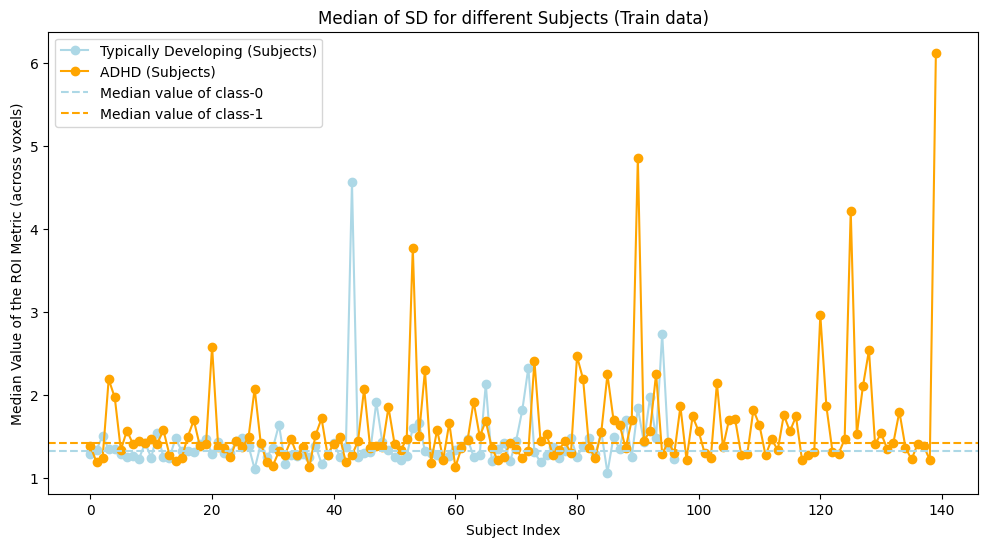

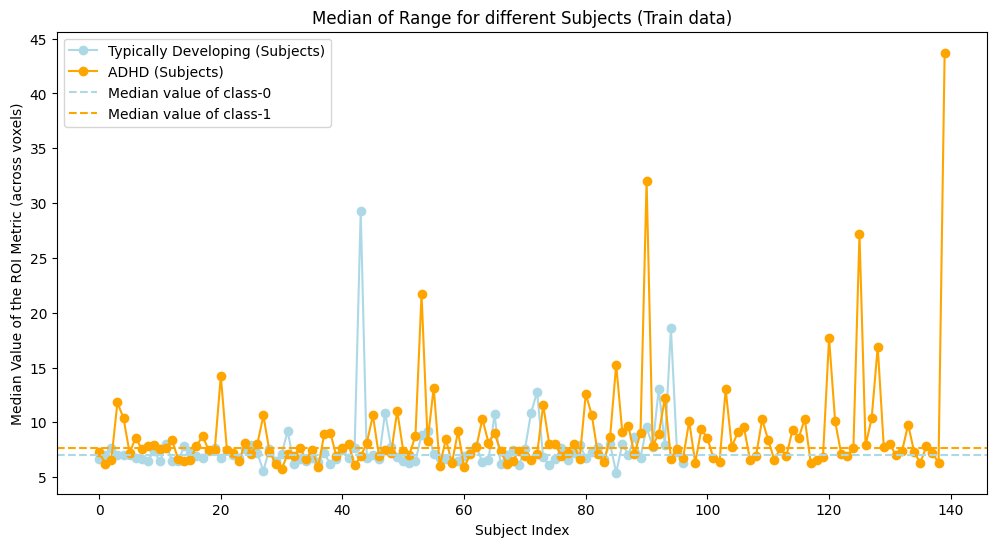

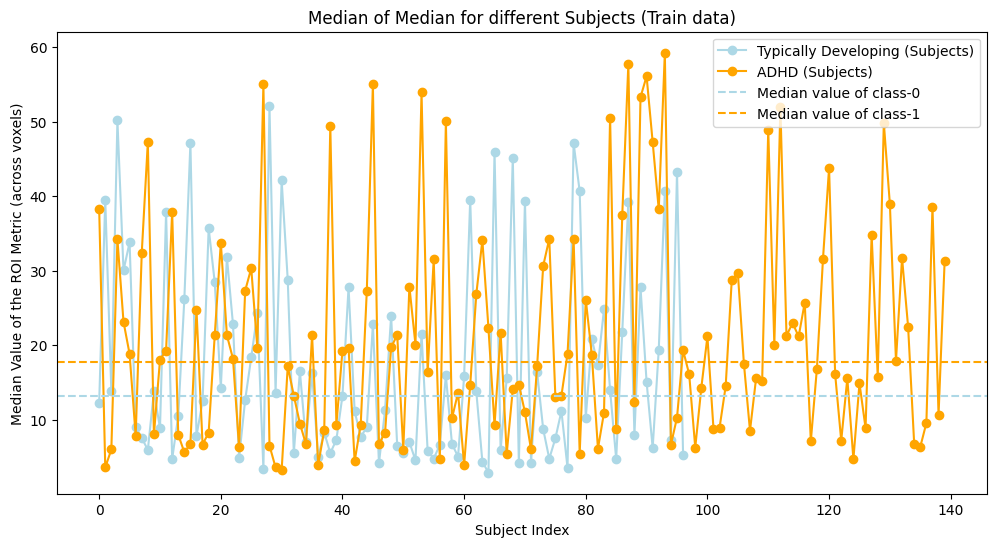

In [68]:
def plot_average_values_per_subject(dataset_path, title):
    # Load the dataset
    df = pd.read_csv(dataset_path) 

    # Separate the data by dx class
    df_class_0 = df[df['dx'] == 0].drop(columns=['sub_id', 'dx'])
    df_class_1 = df[df['dx'] == 1].drop(columns=['sub_id', 'dx'])

    # median of SD across each ROI voxels for class 0(non-ADHD)
    median_values_per_subject_class_0 = df[df['dx'] == 0].drop(columns=['sub_id', 'dx']).median(axis=1)

    # median of SD across each ROI voxels for class 1 (ADHD)
    median_values_per_subject_class_1 = df[df['dx'] == 1].drop(columns=['sub_id', 'dx']).median(axis=1)

    # Calculate the overall median for each class
    overall_avg_class_0 = median_values_per_subject_class_0.median()
    overall_avg_class_1 = median_values_per_subject_class_1.median()

    # Plot the median of SD of each subjects for class 0 and class 1
    plt.figure(figsize=(12, 6))
    plt.plot(median_values_per_subject_class_0.values, marker='o', linestyle='-', color='lightblue', label='Typically Developing (Subjects)')
    plt.plot(median_values_per_subject_class_1.values, marker='o', linestyle='-', color='orange', label='ADHD (Subjects)')

    # Add horizontal dashed lines representing the average for each class
    plt.axhline(y=overall_avg_class_0, color='lightblue', linestyle='--', label='Median value of class-0')
    plt.axhline(y=overall_avg_class_1, color='orange', linestyle='--', label='Median value of class-1')

    plt.title(title)
    plt.xlabel('Subject Index')
    plt.ylabel('Median Value of the ROI Metric (across voxels)')
    plt.legend()
    plt.show()

# Plot for each dataset
plot_average_values_per_subject('dataset_sd_train.csv', 'Median of SD for different Subjects (Train data)')
plot_average_values_per_subject('dataset_range_train.csv', 'Median of Range for different Subjects (Train data)')
plot_average_values_per_subject('dataset_median_train.csv', 'Median of Median for different Subjects (Train data)')

**Using the VOXELS OF INTEREST to classify ADHD using ML models** (To check the significance of our features from Voxels of Interest)

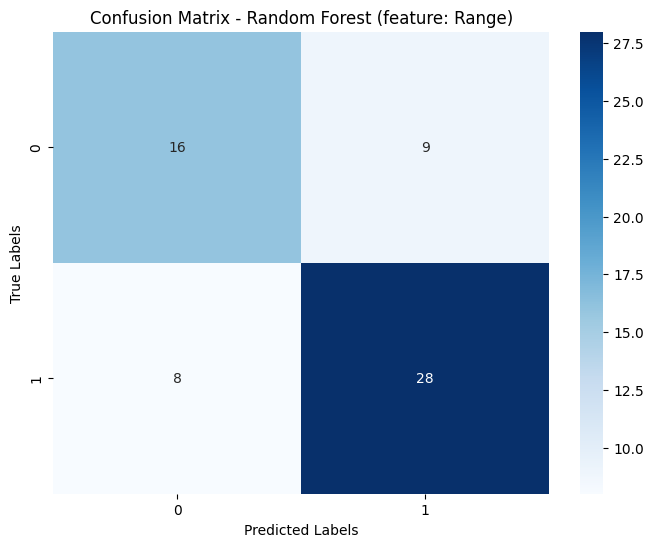

Model: Random Forest (feature: Range)
Accuracy: 0.7213
Precision: 0.7568
Recall: 0.7778
F1 Score: 0.7671



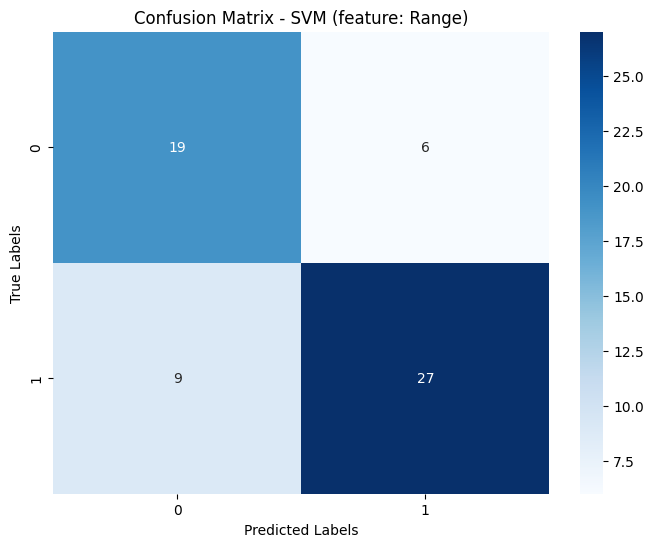

Model: SVM (feature: Range)
Accuracy: 0.7541
Precision: 0.8182
Recall: 0.7500
F1 Score: 0.7826



In [ ]:

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def prepare_data(df):
    # Prepare features and labels from the dataset
    X = df.drop(columns=['sub_id', 'dx'])  # Drop non-feature columns
    y = df['dx']  # Target variable
    return X, y

def plot_confusion_matrix(cm, class_names, model_name):
    """
    Plot the confusion matrix using seaborn's heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)


    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_names = np.unique(y_test) 
    plot_confusion_matrix(cm, class_names, model_name)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Display metrics

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# File paths for training and testing datasets
output_path_train = 'dataset_range_train.csv'
output_path_test = 'dataset_range_test.csv'

# Load and prepare data
train_df, test_df = load_data(output_path_train, output_path_test)
X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)  

# Evaluate models
evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest (feature: Range)")
evaluate_model(svm_model, X_train, y_train, X_test, y_test, "SVM (feature: Range)")


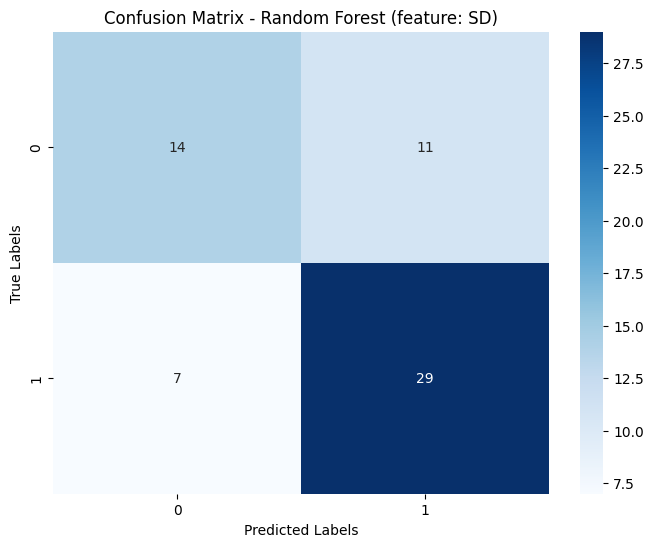

Model: Random Forest (feature: SD)
Accuracy: 0.7049
Precision: 0.7250
Recall: 0.8056
F1 Score: 0.7632



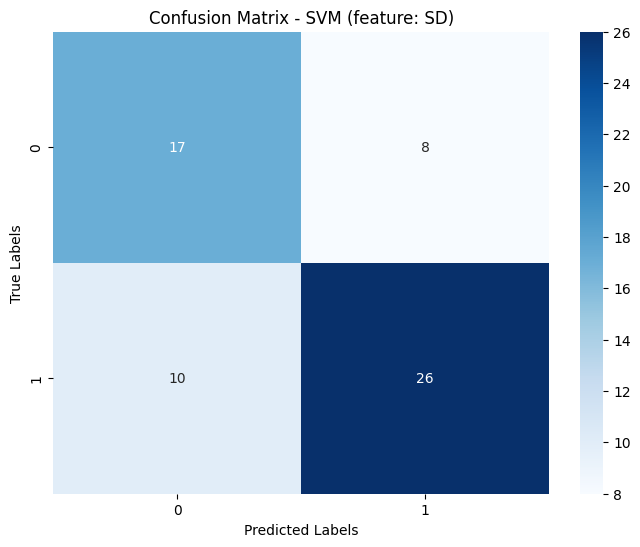

Model: SVM (feature: SD)
Accuracy: 0.7049
Precision: 0.7647
Recall: 0.7222
F1 Score: 0.7429



In [ ]:
# File paths for training and testing datasets (SD)
output_path_train = 'dataset_sd_train.csv'
output_path_test = 'dataset_sd_test.csv'

# Load and prepare data
train_df, test_df = load_data(output_path_train, output_path_test)
X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

 # Initialize models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)  

# Evaluate models
evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest (feature: SD)")
evaluate_model(svm_model, X_train, y_train, X_test, y_test, "SVM (feature: SD)")


**Reducing the features using PCA**

PCA reduced features from 22404 to 129


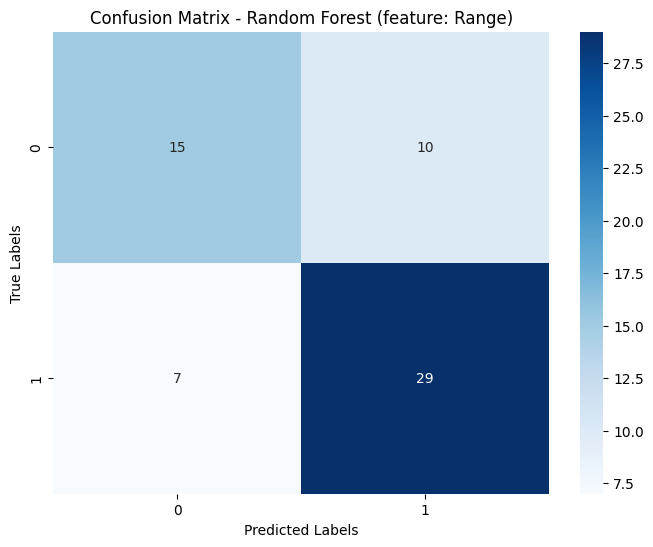

Model Evaluation with PCA - Random Forest (feature: Range)
Testing Accuracy (PCA-transformed): 0.7213
Precision (PCA-transformed): 0.7436
Recall (PCA-transformed): 0.8056
F1 Score (PCA-transformed): 0.7733



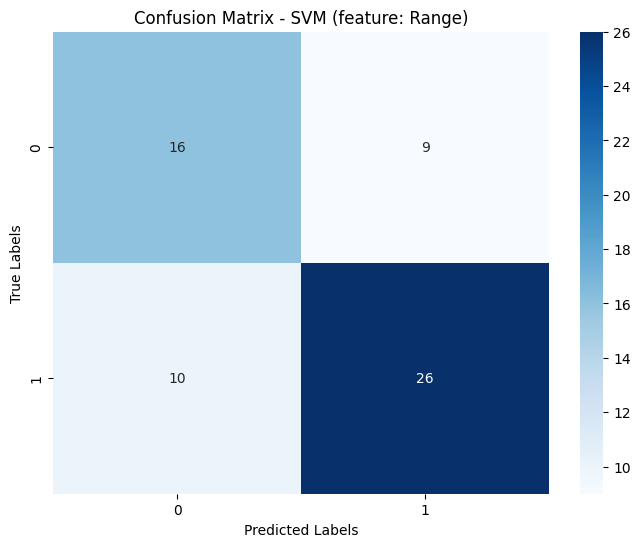

Model Evaluation with PCA - SVM (feature: Range)
Testing Accuracy (PCA-transformed): 0.6885
Precision (PCA-transformed): 0.7429
Recall (PCA-transformed): 0.7222
F1 Score (PCA-transformed): 0.7324



In [64]:

# Standardize the data and apply PCA
def apply_pca(X_train, X_test, n_components):
    """
    Apply PCA to reduce the dimensions of the dataset.
    """
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)

    # Fit PCA on training data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"PCA reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]}")
    return X_train_pca, X_test_pca, pca


# Evaluate models on PCA-transformed data using the provided function
def evaluate_model_with_confusion_matrix(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_names = np.unique(y_test)
    plot_confusion_matrix(cm, class_names, model_name)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"Model Evaluation with PCA - {model_name}")
    print(f"Testing Accuracy (PCA-transformed): {accuracy:.4f}")
    print(f"Precision (PCA-transformed): {precision:.4f}")
    print(f"Recall (PCA-transformed): {recall:.4f}")
    print(f"F1 Score (PCA-transformed): {f1:.4f}\n")

# File paths for training and testing datasets
output_path_train = 'dataset_range_train.csv'
output_path_test = 'dataset_range_test.csv'

# Load and prepare data
train_df, test_df = load_data(output_path_train, output_path_test)
X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)

# Apply PCA to the dataset
X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, n_components=0.95)

# Define models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)


# Evaluate models
evaluate_model_with_confusion_matrix(rf_model, X_train_pca, y_train, X_test_pca, y_test, "Random Forest (feature: Range)")
evaluate_model_with_confusion_matrix(svm_model, X_train_pca, y_train, X_test_pca, y_test, "SVM (feature: Range)")


PCA reduced features from 22404 to 135


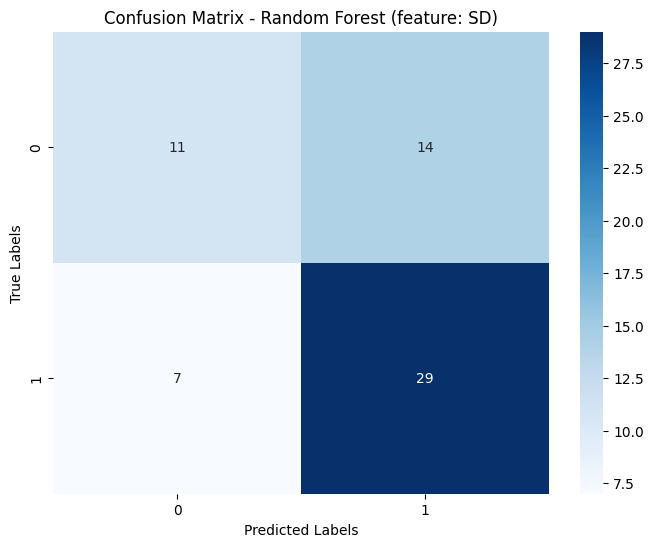

Model Evaluation with PCA - Random Forest (feature: SD)
Testing Accuracy (PCA-transformed): 0.6557
Precision (PCA-transformed): 0.6744
Recall (PCA-transformed): 0.8056
F1 Score (PCA-transformed): 0.7342



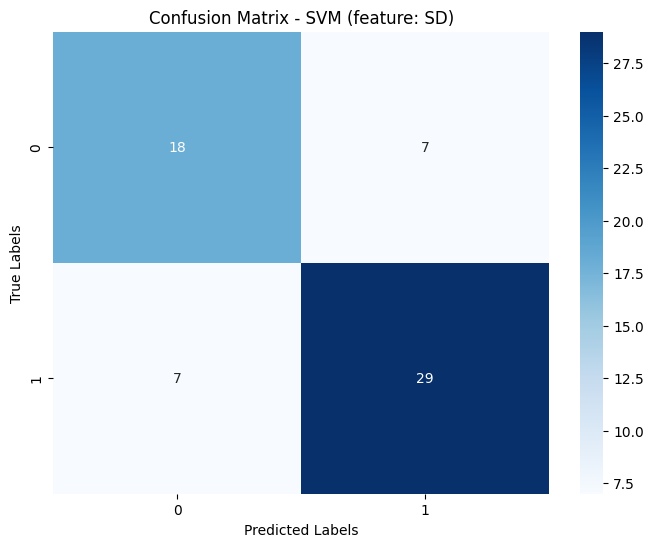

Model Evaluation with PCA - SVM (feature: SD)
Testing Accuracy (PCA-transformed): 0.7705
Precision (PCA-transformed): 0.8056
Recall (PCA-transformed): 0.8056
F1 Score (PCA-transformed): 0.8056



In [65]:
# File paths for training and testing datasets (SD)
output_path_train = 'dataset_sd_train.csv'
output_path_test = 'dataset_sd_test.csv'

# Load and prepare data
train_df, test_df = load_data(output_path_train, output_path_test)
X_train, y_train = prepare_data(train_df)
X_test, y_test = prepare_data(test_df)


# Apply PCA to the dataset
X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, n_components=0.95)

# Define models
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', random_state=42)

# Evaluate models
evaluate_model_with_confusion_matrix(rf_model, X_train_pca, y_train, X_test_pca, y_test, "Random Forest (feature: SD)")
evaluate_model_with_confusion_matrix(svm_model, X_train_pca, y_train, X_test_pca, y_test, "SVM (feature: SD)")